In [2]:
# % load_ext autoreload
# % autoreload 2
from fastai.text.all import *
import fastai

from NLP_Lib import *
from fastai.text import *

# import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import math
import numpy as np
from numpy import dtype
from fastai.text import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle as pkl

import unicodedata
import pandas as pd
import re
import spacy
import json

import fastai
print(fastai.__version__)

import warnings
warnings.filterwarnings('ignore')

# improve/change plot appearance
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# load in the training data, make sure it is the form we expect
training_df = pd.read_table(PATH_TO_TRAINING_DATA)
assert (training_df.shape[1] > 1 and CLASS_COL == training_df.columns[1]
        and training_df.shape[1] > 2 and SUBCLASS_COL == training_df.columns[2]
        and training_df.shape[1] > 3 and TEXT_COL == training_df.columns[3])
        
training_df

2.7.9


In [4]:
training_df["subclass"].value_counts()

Homer Simpson          17255
Marge Simpson           8514
Bart Simpson            7739
Lisa Simpson            6651
C. Montgomery Burns     2106
Ned Flanders            1398
Chief Wiggum            1257
Krusty the Clown        1182
Grampa Simpson          1133
Milhouse Van Houten     1071
Waylon Smithers          624
Name: subclass, dtype: int64

In [5]:
spacy = WordTokenizer()

# Wrapping the Spacy tokenizer with a custom Fastai function to make some custom changes to the tokenizer
tkn = Tokenizer(spacy)
txt = training_df['text'].iloc[0]
tkn(txt)

(#12) ['xxbos','xxmaj','this','looks','like','a','job','for','…','fireplace'...]

In [6]:
txts = L([i for i in training_df['text']])
tok = Tokenizer.from_df(training_df)
tok.setup(training_df)

toks = txts.map(tok)
toks[0]

(#12) ['xxbos','xxmaj','this','looks','like','a','job','for','…','fireplace'...]

In [7]:
tok.encodes(toks[0])
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([   2,    8,   30,  296,   52,   15,  298,   33,   21, 3663])

In [ ]:
training_df["classNumber"] = training_df["subclass"].map({

"Homer Simpson" : 1,
"Marge Simpson" : 2,
"Bart Simpson" : 3,
"Lisa Simpson" : 4,
"C. Montgomery Burns" : 4,
"Ned Flanders" : 5,
"Chief Wiggum" : 6,
"Krusty the Clown" : 7,
"Grampa Simpson" : 8,
"Milhouse Van Houten" : 9,
"Waylon Smithers" : 10
})

print(training_df)



In [9]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.1)
    # using only 10% of entire comments data for validation inorder to learn more
)


dls_lm = dls_lm.dataloaders(training_df, bs=64, seq_len=72)

dls_lm.show_batch(max_n=3)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


,text,text_
0,"xxbos xxmaj and we looked and we saw him … xxbos xxmaj sorry , xxmaj marge -- i got ta break in my ski boots some time . xxbos xxmaj oh hey , is that a xxmaj penn xxmaj state banner ? xxmaj my cousin went there . xxbos xxmaj we 'd better get him home . xxbos xxmaj what , xxmaj i 'm going for a xxmaj xxunk xxunk thing .","xxmaj and we looked and we saw him … xxbos xxmaj sorry , xxmaj marge -- i got ta break in my ski boots some time . xxbos xxmaj oh hey , is that a xxmaj penn xxmaj state banner ? xxmaj my cousin went there . xxbos xxmaj we 'd better get him home . xxbos xxmaj what , xxmaj i 'm going for a xxmaj xxunk xxunk thing . xxmaj"
1,"'ve got to start backwards ! / xxmaj orange to orange ! xxmaj ignore the xxunk ! / xxmaj alternate corners ! / xxbos xxmaj son , they call it a "" xxunk "" . xxmaj whoo hoo ! xxmaj look at him go ! xxbos xxmaj they 're dogs ! xxmaj and they 're playing poker ! xxbos xxmaj we do n't want a raccoon . xxbos xxmaj and read books","got to start backwards ! / xxmaj orange to orange ! xxmaj ignore the xxunk ! / xxmaj alternate corners ! / xxbos xxmaj son , they call it a "" xxunk "" . xxmaj whoo hoo ! xxmaj look at him go ! xxbos xxmaj they 're dogs ! xxmaj and they 're playing poker ! xxbos xxmaj we do n't want a raccoon . xxbos xxmaj and read books where"
2,"look like you in ten days ? xxbos xxmaj hello ? xxmaj xxunk xxmaj xxunk ? xxmaj did you know a man named xxmaj abe xxmaj simpson ? xxbos xxmaj until xxmaj mr . xxmaj roosevelt 's xxmaj new xxmaj deal starts working , this country 's still in a depression . xxmaj i 'm spending a fortune on atoms , and we have to cut costs ! xxbos xxmaj is n't","like you in ten days ? xxbos xxmaj hello ? xxmaj xxunk xxmaj xxunk ? xxmaj did you know a man named xxmaj abe xxmaj simpson ? xxbos xxmaj until xxmaj mr . xxmaj roosevelt 's xxmaj new xxmaj deal starts working , this country 's still in a depression . xxmaj i 'm spending a fortune on atoms , and we have to cut costs ! xxbos xxmaj is n't it"


SuggestedLRs(valley=0.00363078061491251)

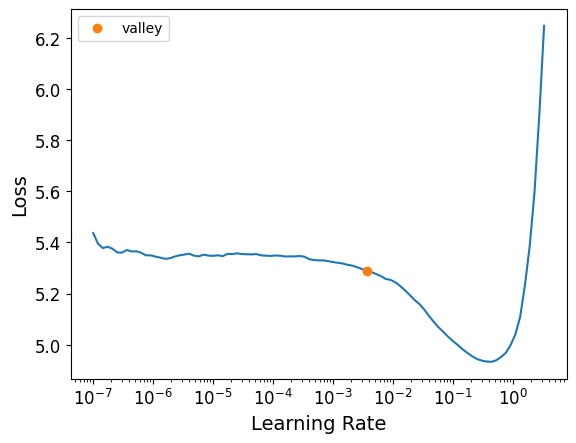

In [10]:
learn = language_model_learner(
    dls_lm, AWD_LSTM,
    metrics=[accuracy, Perplexity()]).to_fp16()

learn.model
learn.lr_find()

In [ ]:
learn.fine_tune(5, 0.00363078061491251)
learn.save_encoder('finetuned')
learn.show_results()
learn.predict()